# Sistemas de Múltiplos Classificadores

Multiple Classifier System (MCS)

***

In [47]:
# importando as bibliotecas 
import pandas as pd
import matplotlib.pyplot as plt

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV


# visualização da árvore
from sklearn.tree import plot_tree

## Conjunto de dados

In [48]:
dataset = pd.read_csv('https://raw.githubusercontent.com/johnattandouglas/monitoria-ml/main/Datasets/Iris.csv')

In [49]:
X = dataset.drop([dataset.columns[-1]], axis = 1)
y = dataset[dataset.columns[-1]]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## Bagging (Bootstrap aggregation)


Vamos avaliar o $RandomForest$

$RandomForest$ é um meta estimador que ajusta vários classificadores de árvore de decisão em várias subamostras do conjunto de dados e usa a **média** para melhorar a precisão preditiva e controlar o ajuste excessivo.

 O tamanho da subamostra é controlado com o parâmetro $max\_samples$ se $bootstrap=True$ (padrão), caso contrário, todo o conjunto de dados é usado para construir cada árvore.

Alguns parâmetros que vamos ajustar: 

 - `n_estimators`: define o número de árvores. Por padrão 100.
 - `criterion`: função de medida da qualidade do split.  Valores possíveis: {“gini”, “entropy”, “log_loss”}
 - `max_depth`: A profundidade máxima da árvore

Confira demais parâmetros [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
model = RandomForestClassifier(random_state=20)

#treinando o modelo
model.fit(X_train, y_train)

#Resultados do classificador
print(model)

#Resultados do classificador
print(classification_report(y_test, model.predict(X_test)))

RandomForestClassifier(random_state=20)
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



**Vamos visualizar as 3 primeiras árvores**

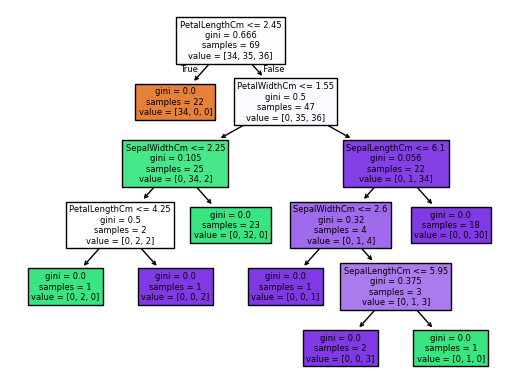

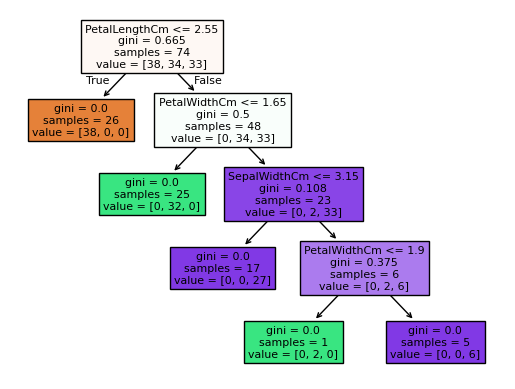

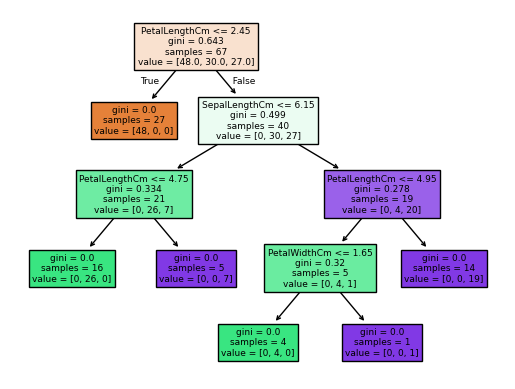

In [53]:
for i in range(3):
    tree = model.estimators_[i]
    # Retorna uma lista contendo os dados para as caixas de anotação que compõem a árvore
    tree = plot_tree(tree, feature_names=X_train.columns, filled=True)
    plt.show()


### Ajuste de parâmetros 

In [54]:
model = RandomForestClassifier(random_state=20)


parameters = {'n_estimators': [50, 100, 150, 200],
              'criterion': ['gini', 'entropy']}

grid = GridSearchCV(estimator = model,             
                    param_grid = parameters,     
                    scoring = 'accuracy',          # métrica de avaliação
                    cv = 5)                        # cross-validation

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print("Melhor parametro:", grid.best_params_) 

Melhor parametro: {'criterion': 'gini', 'n_estimators': 50}


In [55]:
#Modelo final com os melhores parâmetros selecionados 
model = grid.best_estimator_

print(model)

#treinando o modelo
model.fit(X_train, y_train)

#Resultados do classificador
print(classification_report(y_test, model.predict(X_test)))

RandomForestClassifier(n_estimators=50, random_state=20)
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



Agora vamos aplicar um bagging heterogêneo... Para isso vamos usar o [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# Criar os Modelos Heterogêneos
model1 = DecisionTreeClassifier(random_state=42)
model2 = SVC(probability=True, random_state=42)
model3 = KNeighborsClassifier()

# Aplicar Bagging com VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('dt', model1), ('svc', model2), ('knn', model3)],
    voting='soft'  # Usar 'soft' para votar com base nas probabilidades
    # If ‘hard’, uses predicted class labels for majority rule voting. 
    # Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities,
    # which is recommended for an ensemble of well-calibrated classifiers.
)

# Treinar o modelo ensemble
voting_clf.fit(X_train, y_train)

print(classification_report(y_test, voting_clf.predict(X_test)))

print("Acurácias individuais...")
# Avaliar o desempenho dos modelos individuais
for name, model in voting_clf.named_estimators_.items():
    model.fit(X_train, y_train)
    y_pred_individual = model.predict(X_test)
    accuracy_individual = accuracy_score(y_test, y_pred_individual)
    print(f"Acurácia do {name}: {accuracy_individual:.2f}")


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Acurácias individuais...
Acurácia do dt: 0.93
Acurácia do svc: 0.96
Acurácia do knn: 0.98


## Boosting 

Vamos avaliar dois modelos:

[**AdaBoost (Adaptive Boosting)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html): meta-estimador que começa ajustando um classificador no conjunto de dados original e, em seguida, ajusta cópias adicionais do classificador no mesmo conjunto de dados, mas onde os pesos das instâncias classificadas incorretamente são ajustados de forma que os classificadores subsequentes se concentrem mais em casos difíceis.

- Ajusta iterativamente o peso dos exemplos de treinamento com base na dificuldade de classificação. Modelos subsequentes são treinados para corrigir erros dos modelos anteriores.
- Foca em corrigir os erros dos modelos anteriores através do ajuste de pesos dos exemplos classificados incorretamente.
- Combina vários classificadores "fracos" para criar um classificador "forte".

[**XGBoost (Stochastic Gradient Boosting)**](https://xgboost.readthedocs.io/en/stable/): meta-estimador baseado em Decision Trees (árvores de decisão) com Gradient Boosting (aumento de gradiente).

-  Usa o método de boosting baseado em gradiente, onde novos modelos são adicionados para corrigir os erros dos modelos anteriores, mas otimiza a função objetivo com uma abordagem de gradient descent e regularização.
- Minimiza uma função de perda com regularização para melhorar a precisão e reduzir o overfitting.


### Adaboost

In [57]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [58]:
model = AdaBoostClassifier(estimator=None, random_state=20) 
#Quando você não fornece um estimador base, o AdaBoostClassifier usa o DecisionTreeClassifier com max_depth=1 como estimador padrão.

#treinando o modelo
model.fit(X_train, y_train)

#Salvando as predições
y_pred = model.predict(X_test)

print("Parâmetros\n")
print(model.get_params())
# Deprecated since version 1.2: base_estimator is deprecated and will be removed in 1.4. Use estimator instead.
# The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

print("\nEstimator\n")
print(model.estimator_)

#Resultados do classificador
print(classification_report(y_test, model.predict(X_test)))

Parâmetros

{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 20}

Estimator

DecisionTreeClassifier(max_depth=1)
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



C:\Users\johna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


_The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning._

SAMME:
- Stagewise Additive Modeling using a Multiclass Exponential loss function
- Versão multiclasse do AdaBoost original
- Os pesos das amostras são ajustados em cada iteração, e o modelo final é uma combinação ponderada dos classificadores

SAMME.R:
- "R" em SAMME.R significa "Real"
- Versão variante do SAMME que utiliza as probabilidades preditas em vez das classes previstas diretamente para atualizar os pesos das amostras

**Vamos comparar o desempenho dele com uma árvore de decisão**

In [59]:
model_dt = DecisionTreeClassifier(max_depth=1, random_state=20)

#treinando o modelo
model_dt = model_dt.fit(X_train, y_train)

#Salvando as predições
y_pred_dt = model_dt.predict(X_test)

Matriz de Confusão SEM Adaboost:
Acurácia SEM Adaboost: 66.67
Matriz de Confusão COM Adaboost:
Acurácia COM Adaboost: 93.33


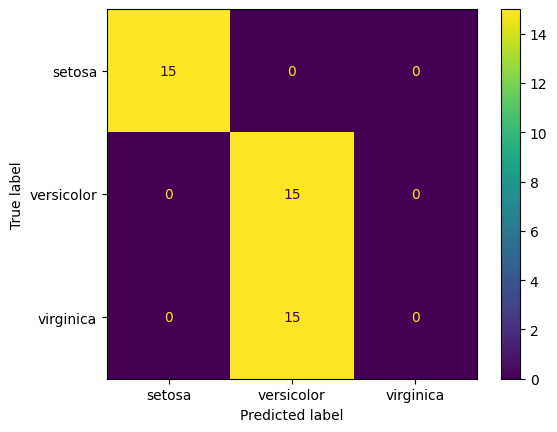

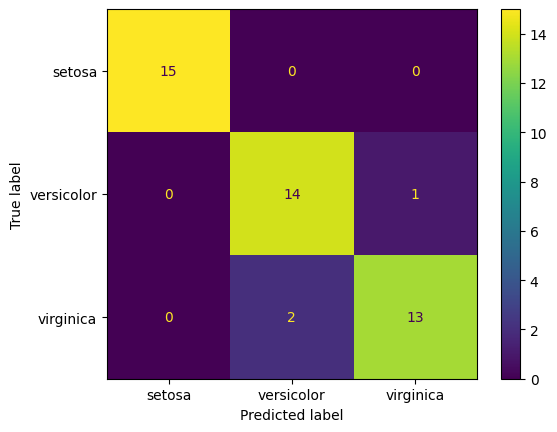

In [60]:
print("Matriz de Confusão SEM Adaboost:")
disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_dt, labels=model_dt.classes_),
                                 display_labels=model.classes_)
disp_cm.plot()
# print(confusion_matrix(y_test, y_pred_dt))
print("Acurácia SEM Adaboost: %.2f" % (accuracy_score(y_test, y_pred_dt)*100))

print("Matriz de Confusão COM Adaboost:")
disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_),
                                 display_labels=model.classes_)
disp_cm.plot()
print("Acurácia COM Adaboost: %.2f" % (accuracy_score(y_test, y_pred)*100))

**Como é possível observar, a adição do Adaboost ao classificador melhora muito sua eficiência.**

**Além disso, abaixo é mostrada a utilização do Adaboost, porém com outro tipo de classificador.**

In [61]:
# Classes do modelo
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [62]:
base_estimator = SVC(kernel='linear', probability=True, random_state=20)

model = base_estimator.fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_ada = AdaBoostClassifier(base_estimator, random_state=20)
model_ada.fit(X_train, y_train)
y_pred_ada = model_ada.predict(X_test)

print("Acurácias")
print("SVM: %.2f" % (accuracy_score(y_test, y_pred)*100))
print("SVM + Adaboost: %.2f" % (accuracy_score(y_test, y_pred_ada)*100))

Acurácias
SVM: 100.00
SVM + Adaboost: 95.56


C:\Users\johna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [63]:
base_estimator = LogisticRegression(random_state=20)

model = base_estimator.fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_ada = AdaBoostClassifier(base_estimator, random_state=20)
model_ada.fit(X_train, y_train)
y_pred_ada = model_ada.predict(X_test)

print("Acurácias")
print("LogisticR: %.2f" % (accuracy_score(y_test, y_pred)*100))
print("LogisticR + Adaboost: %.2f" % (accuracy_score(y_test, y_pred_ada)*100))

C:\Users\johna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Acurácias
LogisticR: 93.33
LogisticR + Adaboost: 91.11


**Disclaimer**: *O AdaBoost foi originalmente projetado para combinar classificadores fracos. SVM e Regressão Logística são considerados classificadores fortes, o que significa que eles já têm um bom desempenho por conta própria. Quando AdaBoost tenta "reforçar" esses modelos, ele pode introduzir ruído ou sobreajuste.*

### XGBoost

Documentação [link](https://xgboost.readthedocs.io/en/stable/).


In [64]:
# Instalando a biblioteca
# !pip install xgboost

In [65]:
from xgboost import XGBClassifier

In [66]:
model = XGBClassifier(random_state=20)

print("Parâmetros\n")
print(model.get_params())

Parâmetros

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 20, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [67]:
# #treinando o modelo
# model.fit(X_train, y_train)

# #Resultados do classificador
# print(model)
# print()

# #Resultados do classificador
# print(classification_report(y_test, model.predict(X_test)))

In [68]:
y_train_ = y_train.map({'versicolor':0,'setosa':1, 'virginica':2})
y_test_ = y_test.map({'versicolor':0,'setosa':1, 'virginica': 2})
# map() é útil quando a série (vetor) é PEQUENA e CONHECIDA


In [69]:
# Problemas de classificação multi-class
model = XGBClassifier(objective="multi:softmax",num_class=3, random_state=20)

#treinando o modelo
model.fit(X_train, y_train_)


#Resultados do classificador
print(classification_report(y_test_, model.predict(X_test)))



              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       1.00      1.00      1.00        15
           2       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45

